In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.datasets as dsets
import torchvision

random.seed(42)

### Designing Encoder (E)

In [2]:
class resBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, k=3, s=1, p=1):
        super(resBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, k, stride=s, padding=p)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, k, stride=s, padding=p)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        return self.bn2(self.conv2(y)) + x
    
class resTransposeBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, k=3, s=1, p=1):
        super(resTransposeBlock, self).__init__()

        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, k, stride=s, padding=p)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, k, stride=s, padding=p)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        return self.bn2(self.conv2(y)) + x

In [3]:
class Encoder(nn.Module):
    def __init__(self, n_res_blocks=5):
        super(Encoder, self).__init__()
        self.n_res_blocks = n_res_blocks
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_1' + str(i+1), resBlock(in_channels=64, out_channels=64, k=3, s=1, p=1))
        self.conv2 = nn.Conv2d(64, 32, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_2' + str(i+1), resBlock(in_channels=32, out_channels=32, k=3, s=1, p=1))
        self.conv3 = nn.Conv2d(32, 8, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_3' + str(i+1), resBlock(in_channels=8, out_channels=8, k=3, s=1, p=1))
        self.conv4 = nn.Conv2d(8, 1, 3, stride=1, padding=1)
    
    def forward(self, x):
        y = self.conv1(x)
        for i in range(self.n_res_blocks):
            y = self.__getattr__('residual_block_1'+str(i+1))(y)
        y = self.conv2(y)
        for i in range(self.n_res_blocks):
            y = self.__getattr__('residual_block_2'+str(i+1))(y)
        y = self.conv3(y)
        for i in range(self.n_res_blocks):
            y = self.__getattr__('residual_block_3'+str(i+1))(y)
        y = self.conv4(y)
        return y

E1 = Encoder()

### Designing Decoder (D)

In [4]:
class Decoder(nn.Module):
    def __init__(self, n_res_blocks=5):
        super(Decoder, self).__init__()
        self.n_res_blocks = n_res_blocks
        self.conv1 = nn.ConvTranspose2d(1, 8, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_1' + str(i+1), resTransposeBlock(in_channels=8, out_channels=8, k=3, s=1, p=1))
        self.conv2 = nn.ConvTranspose2d(8, 32, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_2' + str(i+1), resTransposeBlock(in_channels=32, out_channels=32, k=3, s=1, p=1))
        self.conv3 = nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_3' + str(i+1), resTransposeBlock(in_channels=64, out_channels=64, k=3, s=1, p=1))
        self.conv4 = nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1)
    
    def forward(self, x):
        y = self.conv1(x)
        for i in range(self.n_res_blocks):
            y = self.__getattr__('residual_block_1'+str(i+1))(y)
        y = self.conv2(y)
        for i in range(self.n_res_blocks):
            y = self.__getattr__('residual_block_2'+str(i+1))(y)
        y = self.conv3(y)
        for i in range(self.n_res_blocks):
            y = self.__getattr__('residual_block_3'+str(i+1))(y)
        y = self.conv4(y)
        return y

D1 = Decoder()

### Putting it in box, VAE

In [17]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, batchsz):
        super(VAE, self).__init__()
        self.E = encoder
        self.D = decoder
        self.batchsz = batchsz
        self._enc_mu = nn.Linear(26*26, 128)
        self._enc_log_sigma = nn.Linear(26*26, 128)
        self._din_layer = nn.Linear(128, 26*26)
        
    def _sample_latent(self, h_enc):
        '''
        Return the latent normal sample z ~ N(mu, sigma^2)
        '''
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma
        return mu + sigma * Variable(std_z, requires_grad=False).cuda()  # Reparameterization trick

    def forward(self, x):
        h_enc = self.E(x)
        h_enc = h_enc.view(self.batchsz, 1, -1)
        z = self._sample_latent(h_enc)
        z = self._din_layer(z)
        z = z.view(self.batchsz, 1, 26, 26)
        return self.D(z)

In [18]:
V = VAE(E1, D1, 4)
V = V.cuda()

### Dataloading and stuff


 0
 0
 0
 0
[torch.LongTensor of size 4]



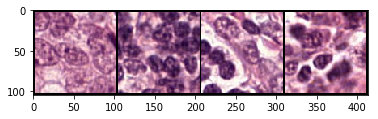

In [41]:
mytransform1 = transforms.Compose(
    [transforms.RandomCrop((101,101)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def mynorm2(x):
    m1 = torch.min(x)
    m2 = torch.max(x)
    return (x-m1)/(m2-m1)

mytransform2 = transforms.Compose(
    [transforms.RandomCrop((101,101)),
     transforms.ToTensor(),
     transforms.Lambda( lambda x : mynorm2(x))])

trainset = dsets.ImageFolder(root='../sample_dataset/train/',transform=mytransform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = dsets.ImageFolder(root='../sample_dataset/test/',transform=mytransform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)
# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def imshow2(img):
    m1 = torch.min(img)
    m2 = torch.max(img)
    img = (img-m1)/(m2-m1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #all the images under the same 'unlabeled' folder
print(labels)
# show images
imshow(torchvision.utils.make_grid(images))


testiter = iter(testloader)

### training thingy

In [8]:
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

In [34]:
testX, _ = next(testiter)
def eval_model(model):
    X = testX
    print('input looks like ...')
    plt.figure()
    imshow(torchvision.utils.make_grid(X))
    
    X = Variable(X).cuda()
    Y = model(X)
    print('output looks like ...')
    plt.figure()
    imshow2(torchvision.utils.make_grid(Y.data.cpu()))

In [48]:
def train(model, rec_interval=2, disp_interval=20, eval_interval=1):
    nepoch = 100
    Criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_track = []
    for eph in range(nepoch):
        dataloader = iter(trainloader)
        print('starting epoch {} ...'.format(eph))
        for i, (X, _) in enumerate(dataloader):
            X = Variable(X).cuda()
            optimizer.zero_grad()
            reconX = model(X)
            KLTerm = latent_loss(model.z_mean, model.z_sigma)
            reconTerm = Criterion(reconX, X)
            loss = reconTerm + KLTerm
            loss.backward()
            optimizer.step()
            
            if i%rec_interval == 0:
                loss_track.append(loss.data[0])
            if i%disp_interval == 0:
                print('epoch : {}, iter : {}, KLterm : {}, reconTerm : {}, totalLoss : {}'.format(eph, i, KLTerm.data[0], reconTerm.data[0], loss.data[0]))
        
#         if eph%eval_interval == 0:
#             print('after epoch {} ...'.format(eph))
#             eval_model(model)
    return loss_track

In [49]:
loss_track = train(V, disp_interval=45)

starting epoch 0 ...
epoch : 0, iter : 0, KLterm : 2.412521280348301e-05, reconTerm : 0.046766750514507294, totalLoss : 0.04679087549448013
epoch : 0, iter : 45, KLterm : 2.4233246222138405e-05, reconTerm : 0.03345980867743492, totalLoss : 0.033484041690826416
epoch : 0, iter : 90, KLterm : 2.0720064640045166e-05, reconTerm : 0.04123181849718094, totalLoss : 0.041252538561820984
epoch : 0, iter : 135, KLterm : 1.7326907254755497e-05, reconTerm : 0.04060438647866249, totalLoss : 0.04062171280384064
epoch : 0, iter : 180, KLterm : 1.4375196769833565e-05, reconTerm : 0.041217390447854996, totalLoss : 0.04123176634311676
epoch : 0, iter : 225, KLterm : 1.811946276575327e-05, reconTerm : 0.040163736790418625, totalLoss : 0.040181856602430344
starting epoch 1 ...
epoch : 1, iter : 0, KLterm : 2.104963641613722e-05, reconTerm : 0.05852659419178963, totalLoss : 0.05854764208197594
epoch : 1, iter : 45, KLterm : 1.7955084331333637e-05, reconTerm : 0.03967121243476868, totalLoss : 0.039689168334

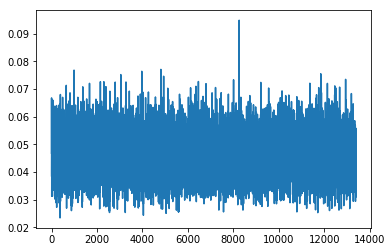

In [50]:
plt.plot(loss_track)

input looks like ...
output looks like ...


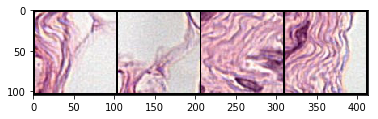

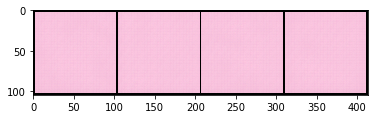

In [53]:
eval_model(V)